In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, FloatSlider
from keras.models import Sequential, Model
from keras.layers import (Input, Lambda, concatenate, Dense)
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [2]:
#Load
(x_train_0, y_train_0), (x_test_0, y_test_0) = mnist.load_data()

In [3]:
#Reshape
x_train = x_train_0.reshape(60000, -1)
x_test = x_test_0.reshape(10000, -1)

In [4]:
#normalization
x_train_norm = x_train
x_train_norm -= x_train_norm.min()
x_train_norm = x_train_norm / x_train_norm.max()

In [5]:
#VAE 的建立(enncoder)
x = Input(shape=(784,))
enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(50, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

In [6]:
#sample
def sampling(args):
    m, v = args
    epsilon = K.random_normal(shape=(2,), mean=0, stddev = 1)
    return m + K.exp(v / 2) * epsilon

In [7]:
#decoder
dec_1 = Dense(50, activation='sigmoid')
dec_2 = Dense(100, activation='sigmoid')
dec_3 = Dense(784, activation='sigmoid')

In [8]:
#connect
h1 = enc_1(x)
h2 = enc_2(h1)
h3m = enc_mean(h2)
h3v = enc_log_var(h2)

z = Lambda(sampling, output_shape=(2, ))([h3m, h3v])

dh1 = dec_1(z)
dh2 = dec_2(dh1)
x_hat = dec_3(dh2)

VAE = Model(x, x_hat)
VAE.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           5050        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            102         dense_2[0][0]                    
_____________________________________

In [9]:
#Loss function
def loss(x,x_recon):
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + h3v - K.square(h3m) - K.exp(h3v), axis= -1)
    return recovery_loss + kl_loss

In [10]:
VAE.compile(loss= loss, optimizer=Adam())

In [11]:
VAE.fit(x_train_norm, x_train_norm, batch_size=32, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 18s 294us/step - loss: 203.2338
Epoch 2/10
60000/60000 [==============================] - 16s 269us/step - loss: 189.6326
Epoch 3/10
60000/60000 [==============================] - 16s 264us/step - loss: 176.5125
Epoch 4/10
60000/60000 [==============================] - 16s 264us/step - loss: 167.9792
Epoch 5/10
60000/60000 [==============================] - 16s 273us/step - loss: 163.3980
Epoch 6/10
60000/60000 [==============================] - 16s 272us/step - loss: 159.7642
Epoch 7/10
60000/60000 [==============================] - 17s 288us/step - loss: 157.34001s - loss: 157.3
Epoch 8/10
60000/60000 [==============================] - 17s 289us/step - loss: 155.4513
Epoch 9/10
60000/60000 [==============================] - 16s 273us/step - loss: 154.0967
Epoch 10/10
60000/60000 [==============================] - 17s 278us/step - loss: 152.8111


In [12]:
#視覺化VAE(encoder)
VAE_Encoder = Model(x, h3m)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 83,652
Trainable params: 83,652
Non-trainable params: 0
_________________________________________________________________


In [13]:
h_input = Input(shape=(2, ))
VAE_Decoder = Model(h_input, dec_3(dec_2(dec_1(h_input))))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               79184     
Total params: 84,434
Trainable params: 84,434
Non-trainable params: 0
_________________________________________________________________


In [14]:
index = np.random.randint(x_test.shape[0], size=1000)
VAE_latent = VAE_Encoder.predict(x_test[index])

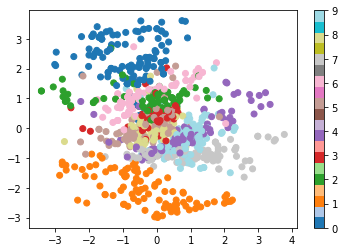

In [15]:
plt.scatter(VAE_latent[:,0], VAE_latent[:,1], c=y_test_0[index], cmap='tab20')
plt.colorbar()

(-0.5, 419.5, 419.5, -0.5)

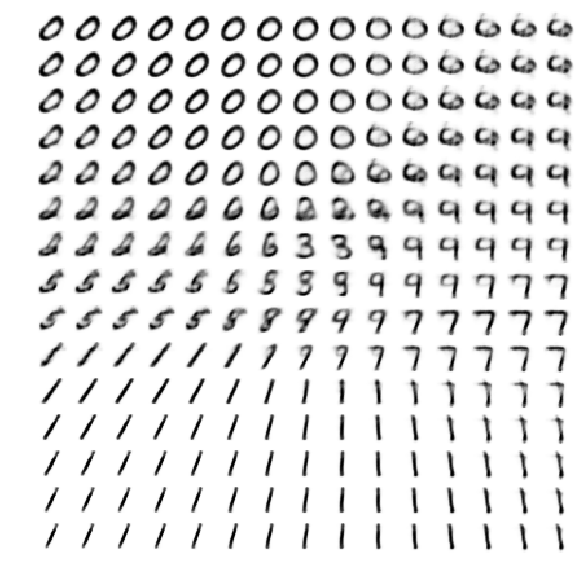

In [16]:
#視覺化(decoder)
def norm(x):
    t = x
    t -= t.min()
    t /= t.max()
    return t

n = 15
digit_size = 28
gd_x = np.linspace(-4 + 0.05, 4-0.05, n)
gd_y = np.linspace(-4 + 0.05, 4-0.05, n)
fig = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(gd_x):
    for j, xi in enumerate(gd_y):
        z = np.array([[xi, yi]])
        x_dec = VAE_Decoder.predict(z)
        digit = x_dec[0].reshape(digit_size, digit_size)
        fig[(n-i-1) * digit_size : (n-i) * digit_size,
           j * digit_size : (j+1) * digit_size] = norm(digit)
plt.figure(figsize=(10,10))
plt.imshow(fig, cmap='Greys')
plt.axis('off')

In [27]:
def inBetween(t):
    data_0 = x_train_0[idx_1]
    data_1 = x_train_0[idx_2]
    data_t = (1-t)*x_train_0[idx_1] + t*x_train_0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='bone')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [28]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train_0[idx_1]
data_1 = x_train_0[idx_2]

In [29]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>